In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import sys
import matplotlib as mpl
sys.path.append("/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMe/python_analysis/analysisTools")
import plotTools as ptools

In [2]:
f_sig = "signal_v2_2018_aEM_ejdR_rejection_IDcut.coffea"
sig = util.load(f_sig)[0]

In [3]:
cutflows = ['cutDesc', 'cutflow', 'cutflow_cts']
histos = [k for k in sig.keys() if k not in cutflows]
sig_samples = list(sig['cutflow'].keys())
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples},orient='index')
cuts = list(sig['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig['cutDesc'][cname]) for cname in sig['cutDesc'].keys()}
deltas = sorted(list(set(si.delta)))
ctaus = sorted(list(set(si.ctau)))

In [4]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
def plot(hname,xlim,extra=None,rej=False,rebin=1j,logy=False,scaley=5,xlabel=None,density=False,ylim=None,cut='cut7'):
    all_ctaus = sorted(list(set(si.ctau)))
    for delta in deltas:
        fig,axes = plt.subplots(1,len(all_ctaus),figsize=(4*len(all_ctaus),4))
        m1s = sorted(list(set(si[si.delta==delta].m1)))
        for j,m1 in enumerate(m1s):
            ctaus = sorted(list(set(si[(si.delta==delta)&(si.m1==m1)].ctau)))
            for i,ct in enumerate(all_ctaus):
                if ct not in ctaus:
                    continue
                plt.sca(axes[i])
                plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
                point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                if rej:
                    hs = sig_rej[hname]
                else:
                    hs = sig[hname]
                if extra is not None:
                    hs = extra(hs)[{"samp":point,"cut":cut}][::rebin]
                else:
                    hs = hs[{"samp":point,"cut":cut}][::rebin]
                hs.plot1d(label=r"$M_1 = {0}$".format(m1),yerr=False,density=density,color=f"C{j}")
        for i in range(len(all_ctaus)):
            plt.sca(axes[i])
            if logy:
                plt.yscale('log')
            if xlim:
                plt.xlim(xlim)
            ylo,yhi = plt.gca().get_ylim()
            if ylim:
                plt.ylim(ylim)
            else:
                plt.ylim([ylo,scaley*yhi])
            if xlabel:
                plt.xlabel(xlabel)

            if i==0:
                ncol = 2
                leg_entries = [Line2D([0],[0],color=f"C{j}",label=r"$M_1 = {0}$".format(m1s[j])) for j in range(len(m1s))]                    
                plt.gca().legend(handles=leg_entries,loc='upper center',bbox_to_anchor=(0.5,1),fontsize=9,ncol=ncol)
        plt.tight_layout()
        outDir = f"plots/histos/{cut}/sigOnly/{hname}/delta_{delta:.1f}/"
        outName = f"ct-all.pdf"
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f"{outDir}/{outName}")
        
        # new figures split up by ctau
        ctaus = sorted(list(set(si[(si.delta==delta)].ctau)))
        for ct in ctaus:
            plt.figure(figsize=(8,6))
            m1s = sorted(list(set(si[(si.delta==delta)&(si.ctau==ct)].m1)))
            for k,m1 in enumerate(m1s):
                point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                if extra is None:
                    hs = sig[hname][{"samp":point,"cut":cut}][::rebin]
                else:
                    hs = extra(sig[hname])[{"samp":point,"cut":cut}][::rebin]
                hs.plot1d(label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{k}")
            if logy:
                plt.yscale('log')
            if xlim:
                plt.xlim(xlim)
            ylo,yhi = plt.gca().get_ylim()
            plt.ylim([ylo,scaley*yhi])
            if xlabel:
                plt.xlabel(xlabel)
            ncol = 3
            plt.legend(loc='upper center',bbox_to_anchor=(0.5,1),fontsize=12,ncol=ncol)
            plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
            plt.tight_layout()
            outName = f"ct-{ct}.pdf"
            plt.savefig(f"{outDir}/{outName}")
            plt.close()

In [7]:
def plot_compare(hname,xlim,rebin=1j,logy=False,scaley=5,xlabel=None,density=False,ylim=None):
    for delta in deltas:
        plt.figure(figsize=(16,4))
        m1s = sorted(list(set(si[si.delta==delta].m1)))
        for i,ct in enumerate(ctaus):
            plt.subplot(1,4,i+1)
            plt.title(r"$c\tau = {0}$ mm".format(ct))
            for j,m1 in enumerate(m1s):
                point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                hs = sig[hname][point,cut,::rebin]
                hs_rej = sig_rej[hname][point,cut,::rebin]
                hs.plot1d(label=r"$M_1 = {0}$".format(m1),yerr=False,density=density,color=f"C{j}")
                hs_rej.plot1d(label="w/ jet dR rejection".format(m1),yerr=False,density=density,color=f"C{j}",linestyle='--')
                
            
            if logy:
                plt.yscale('log')
            if xlim:
                plt.xlim(xlim)
            ylo,yhi = plt.gca().get_ylim()
            if ylim:
                plt.ylim(ylim)
            else:
                plt.ylim([ylo,scaley*yhi])
            if xlabel:
                plt.xlabel(xlabel)
            
            ncol = min((len(m1s)+1) // 2 + (len(m1s)+1)%2,3)
            if i==0:
                plt.gca().legend(loc='upper center',bbox_to_anchor=(0.5,1),fontsize=7,ncol=ncol)
        
        plt.suptitle(r"$\Delta = {0:.1f}$".format(delta))
        plt.savefig(f"plots/histos/sigOnly_{hname}_delta{delta:.1f}_jetRejVsDefault.pdf")
        plt.tight_layout()

In [8]:
def plot2d(hname,rebinx=1j,rebiny=1j,logy=False,scaley=5,xlabel=None,density=False,xlim=None,ylim=None,save=False):
    for delta in [0.1,0.2]:
        m1s = sorted(list(set(si[si.delta==delta].m1)))
        for m1 in m1s:
            plt.figure(figsize=(16,4))
            for i,ct in enumerate(ctaus):
                plt.subplot(1,4,i+1)
                point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                hs = sig[hname][{"samp":point,"cut":cut}][::rebinx,::rebiny]
                hs.plot2d(flow=True)
                plt.title(r"$m_1 = {0:.1f}$, $\Delta = {1:.1f}$, $c\tau = {2}$ mm".format(m1,delta,ct))
                if xlim:
                    plt.xlim(xlim)
                if ylim:
                    plt.ylim(ylim)
                """if logy:
                    plt.yscale('log')
                if xlim:
                    plt.xlim(xlim)
                ylo,yhi = plt.gca().get_ylim()
                if ylim:
                    plt.ylim(ylim)
                else:
                    plt.ylim([ylo,scaley*yhi])
                if xlabel:
                    plt.xlabel(xlabel)

                ncol = min((len(m1s)+1) // 2 + (len(m1s)+1)%2,3)
                if i==0:
                    plt.gca().legend(loc='upper center',bbox_to_anchor=(0.5,1),fontsize=7,ncol=ncol)"""
            plt.tight_layout()
            if save:
                plt.savefig(f"plots/histos_2d/sigOnly_{hname}_m1{m1:.1f}_delta{delta:.1f}.png")

# Plot vertex match types

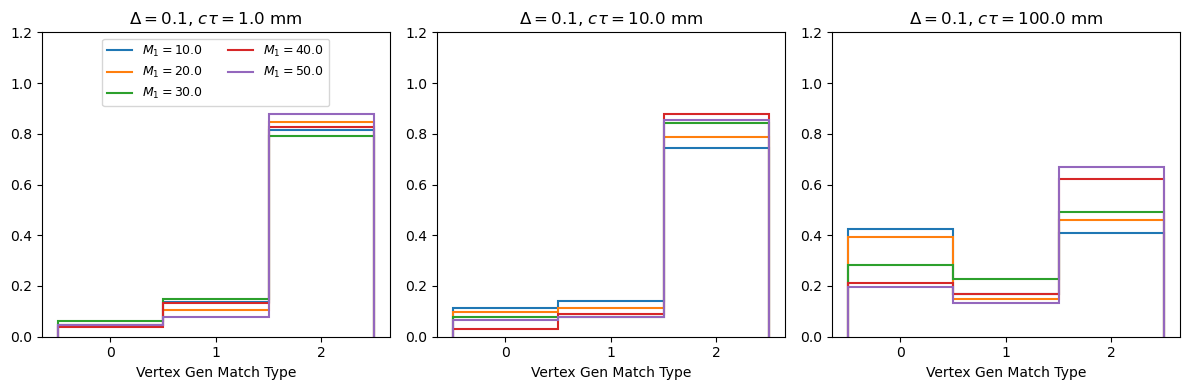

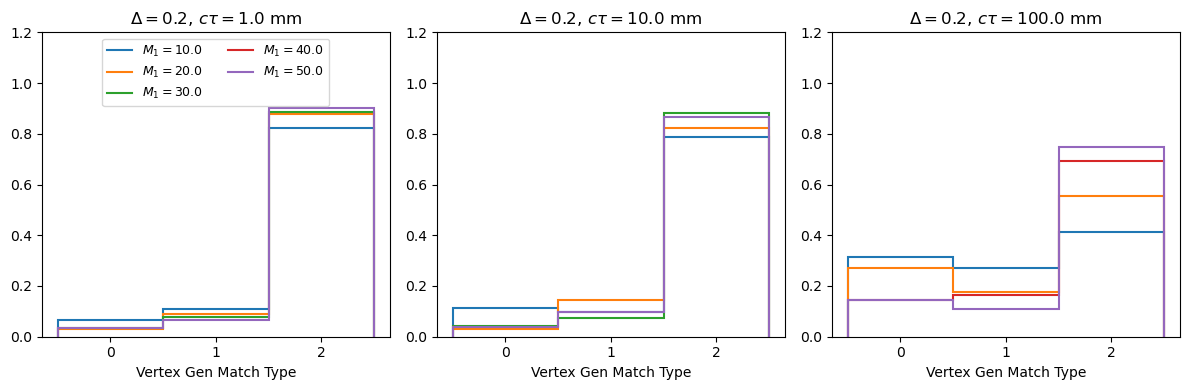

In [5]:
# electron 1 PF isolation dR < 0.3
plot("sel_vtx_matchType",None,logy=False,rebin=1j,density=True,ylim=[0,1.2],cut="cut7")

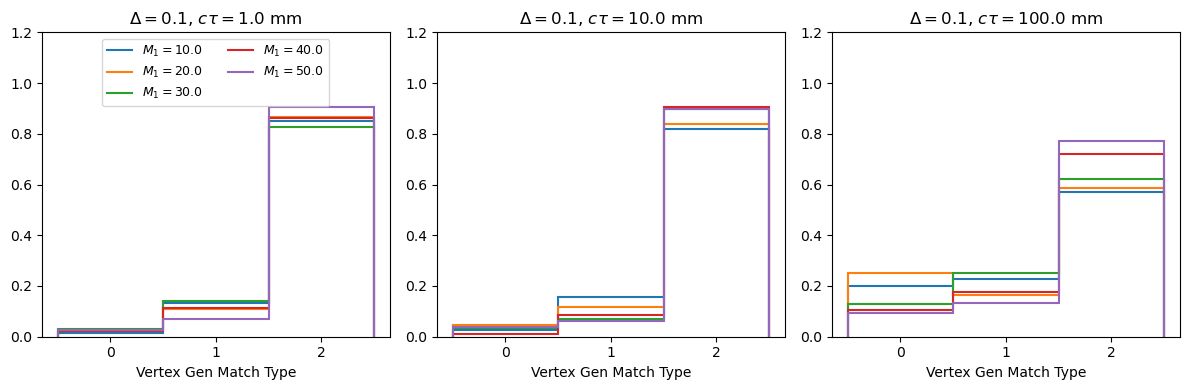

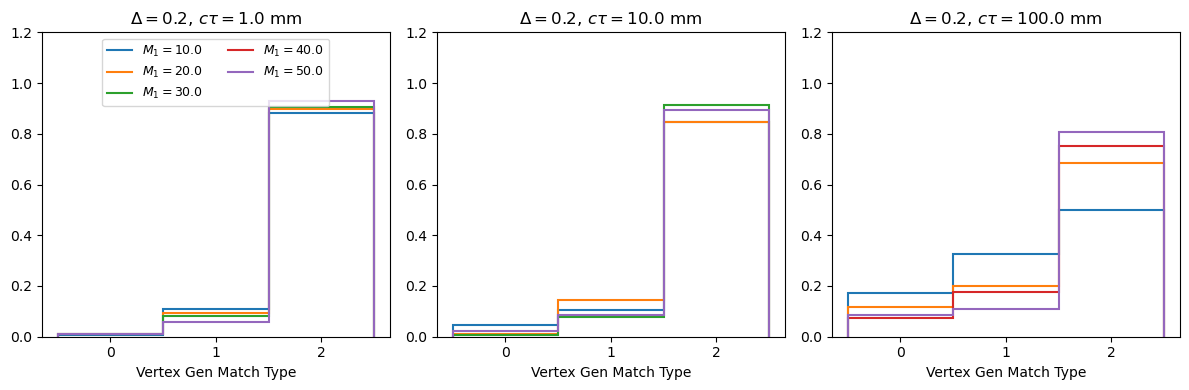

In [6]:
# electron 1 PF isolation dR < 0.3
plot("sel_vtx_matchType",None,logy=False,rebin=1j,density=True,ylim=[0,1.2],cut="cut8")

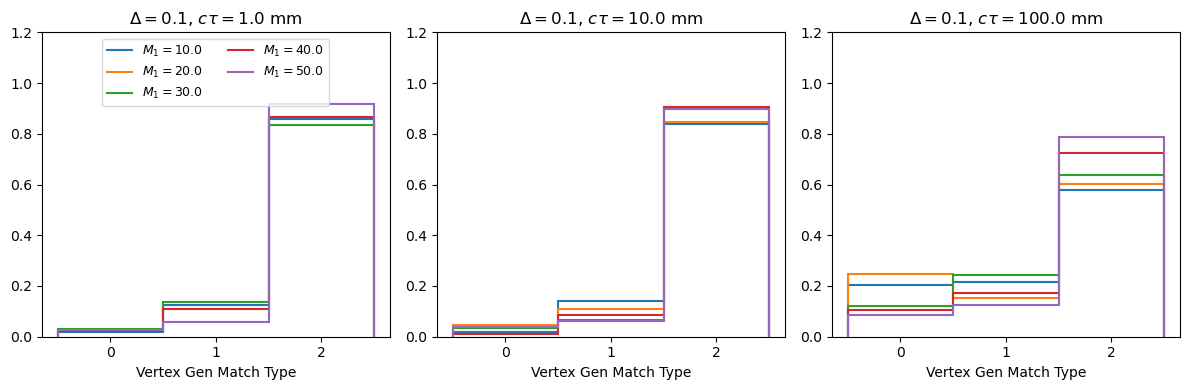

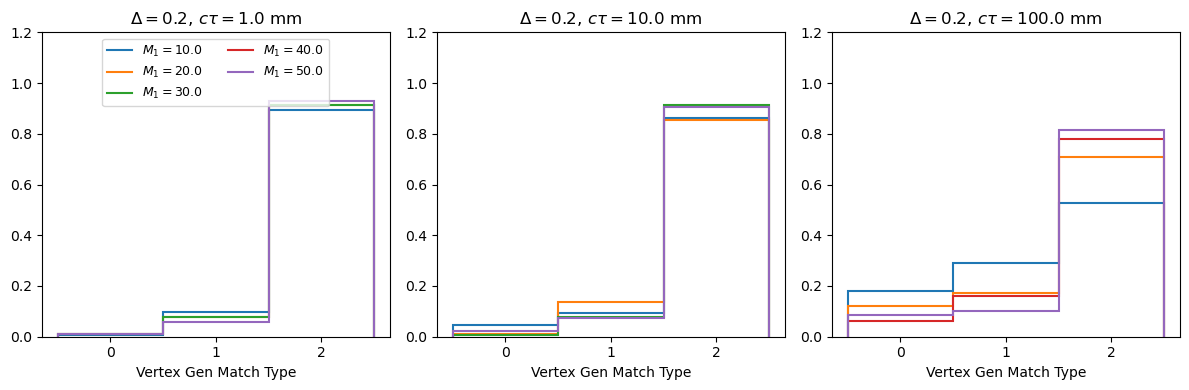

In [7]:
# electron 1 PF isolation dR < 0.3
plot("sel_vtx_matchType",None,logy=False,rebin=1j,density=True,ylim=[0,1.2],cut="cut9")

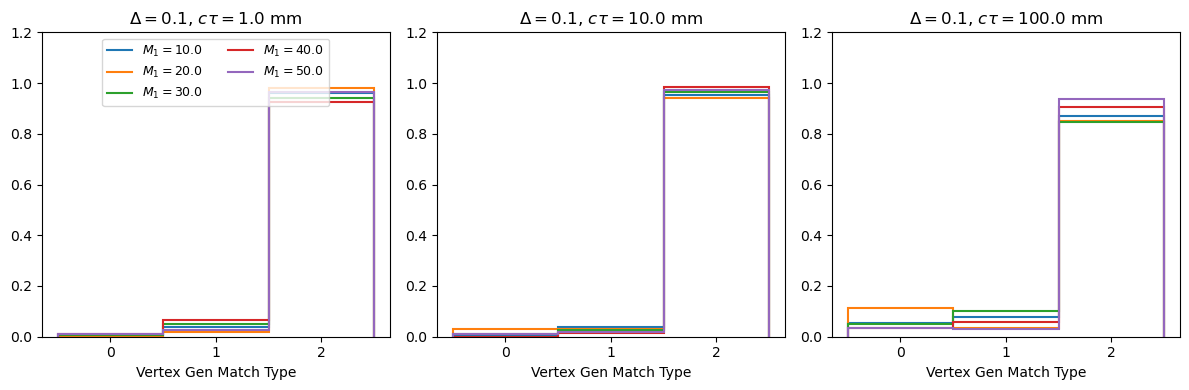

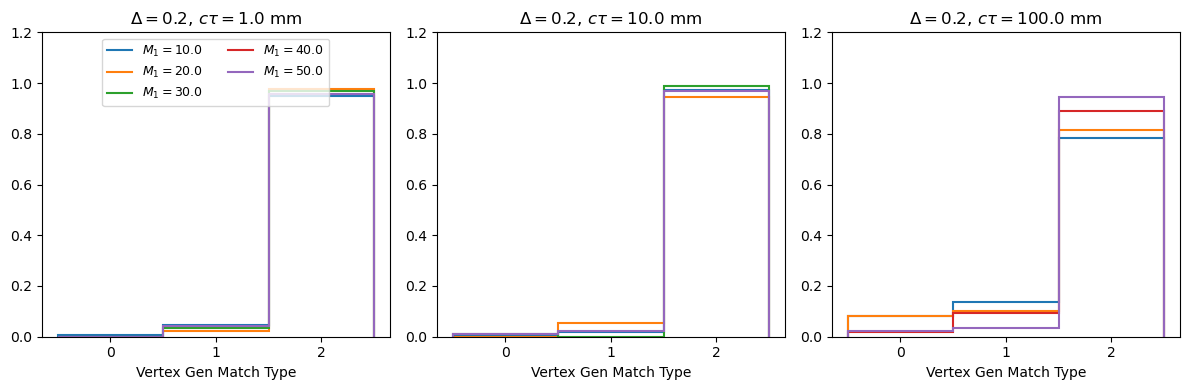

In [8]:
# electron 1 PF isolation dR < 0.3
plot("sel_vtx_matchType",None,logy=False,rebin=1j,density=True,ylim=[0,1.2],cut="cut10")

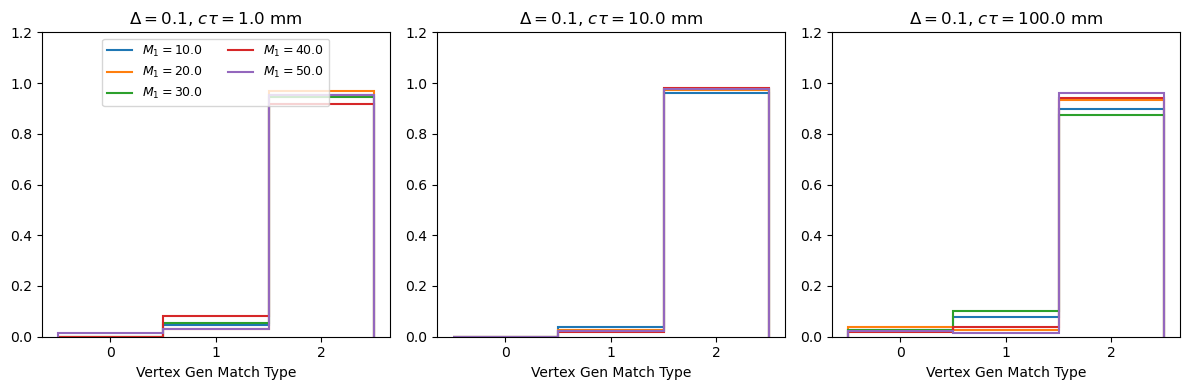

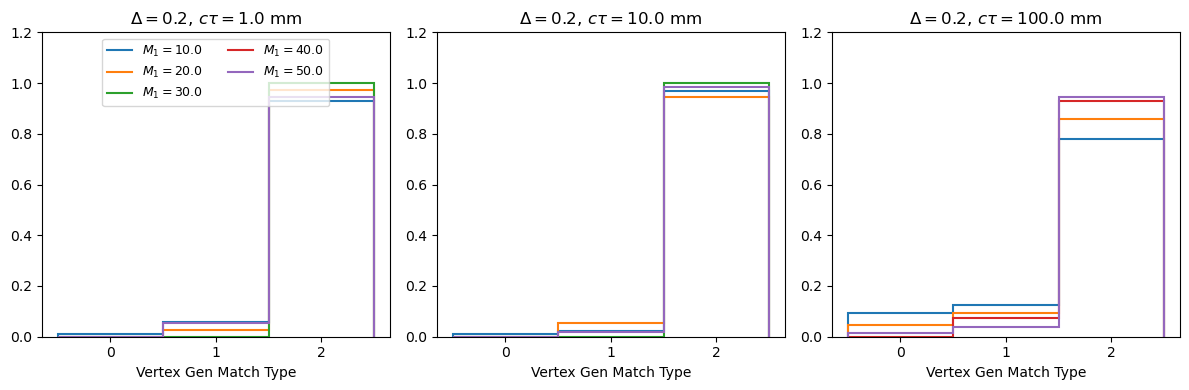

In [5]:
# electron 1 PF isolation dR < 0.3
plot("sel_vtx_matchType",None,logy=False,rebin=1j,density=True,ylim=[0,1.2],cut="cut11")

# MET dPhi by match type

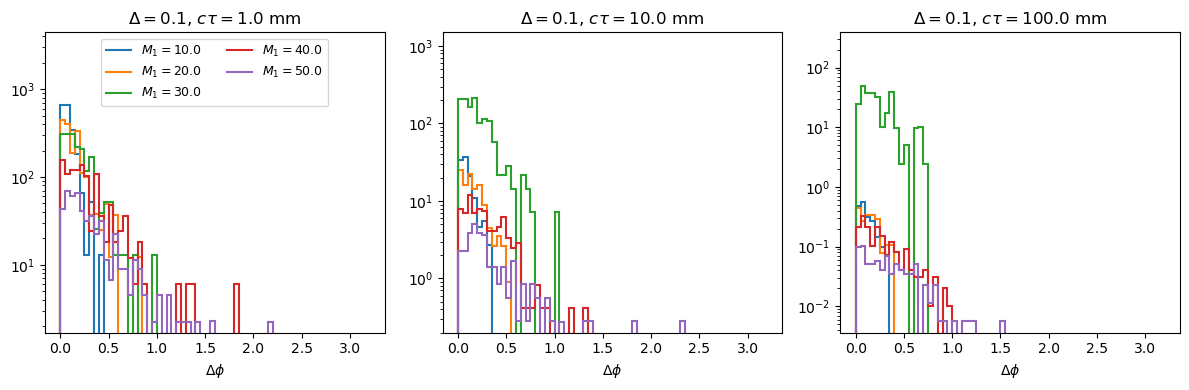

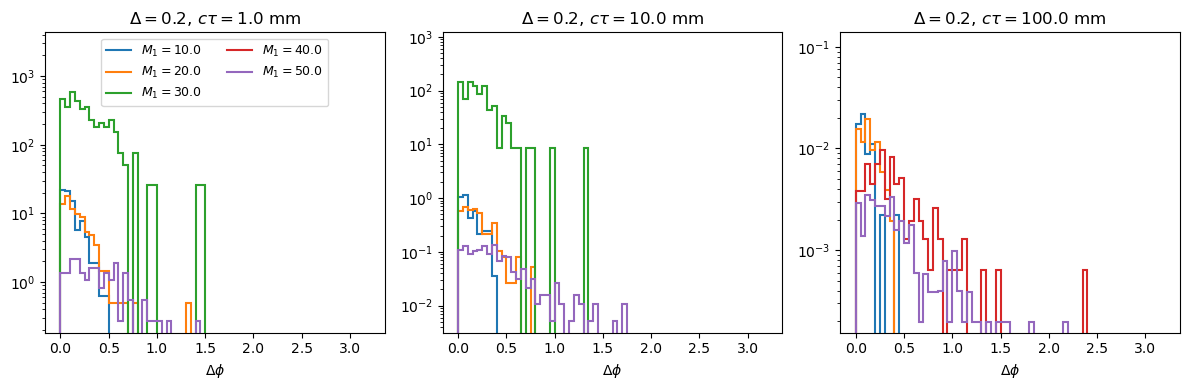

In [7]:
extra = lambda x : x[{"mtype":2}]
plot("sel_vtx_METdPhi_vs_matchType",None,extra=extra,logy=True,cut='cut7')

# Gen electron-vertex dR

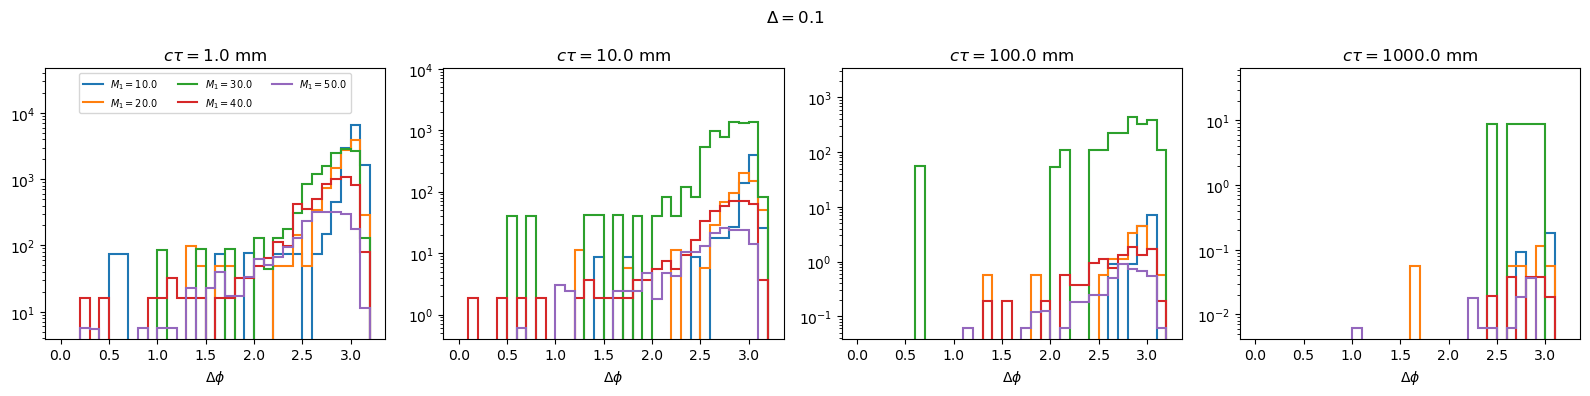

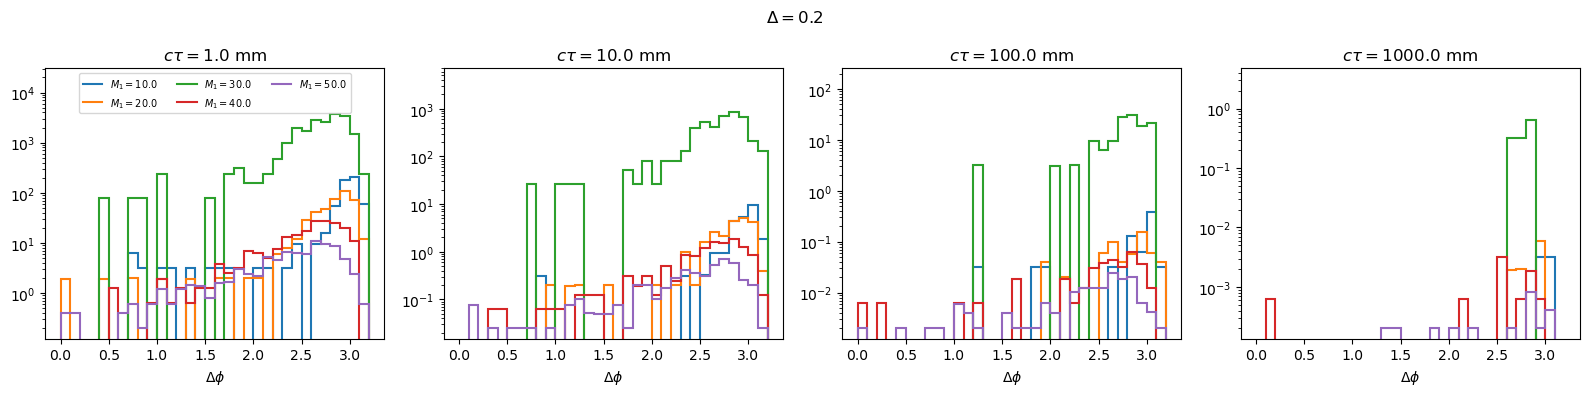

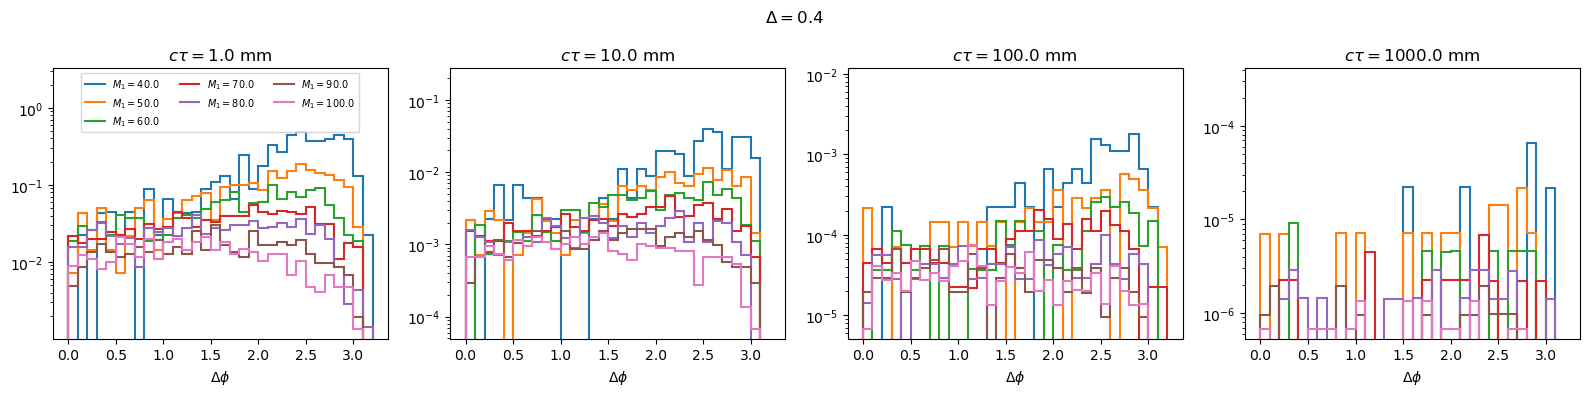

In [15]:
extra = lambda x: x[{"mtype":2}]
plot("sel_vtx_minEledPhiJ_vs_matchType",None,extra=extra,rej=True,logy=True,rebin=1j)

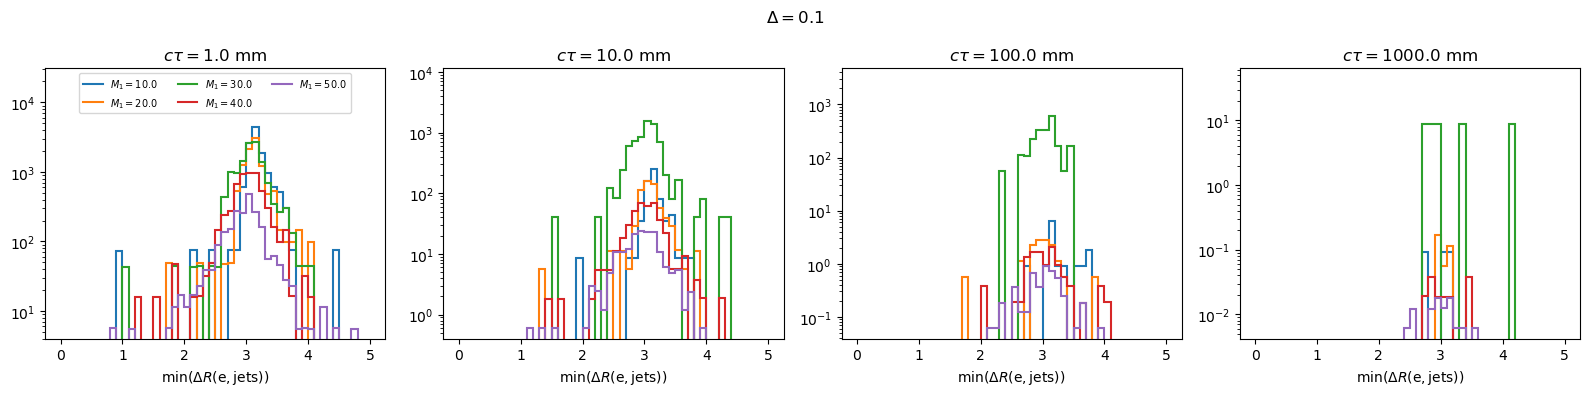

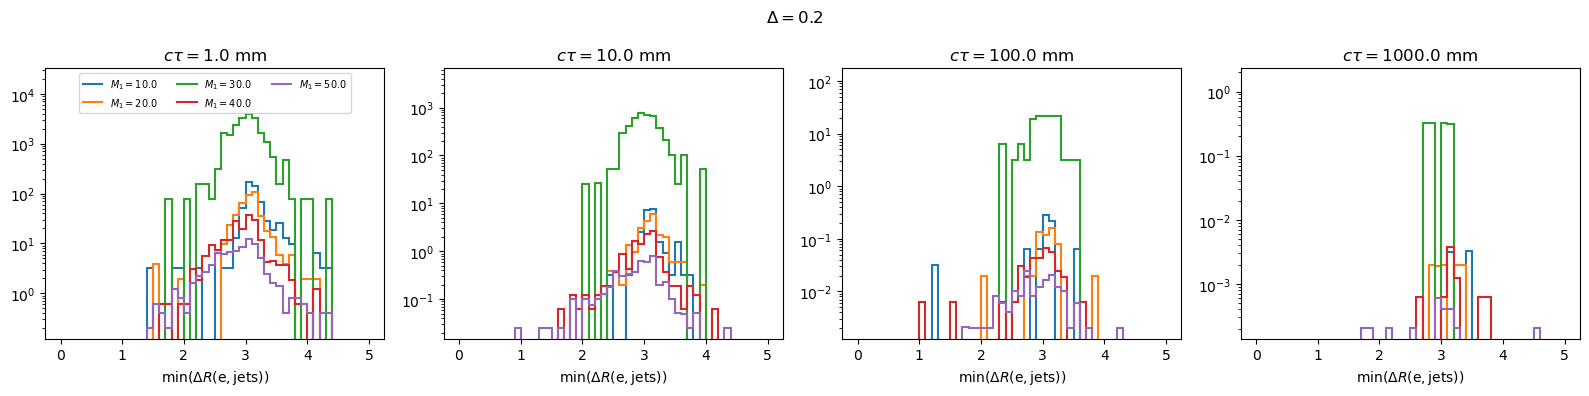

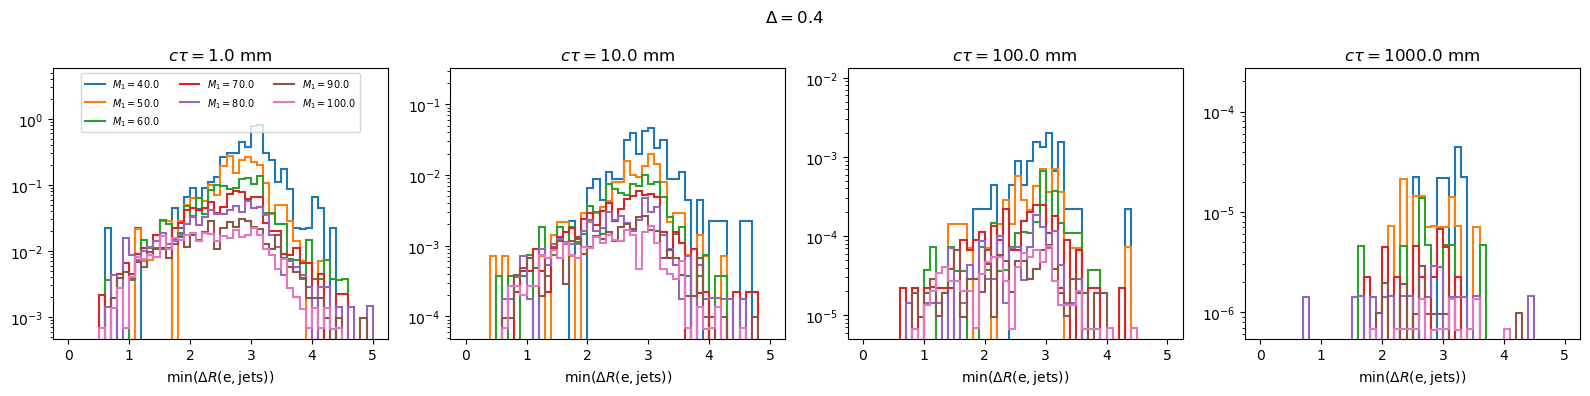

In [16]:
extra = lambda x: x[{"mtype":2}]
plot("sel_vtx_mindRj_vs_matchType",None,extra=extra,rej=True,logy=True,rebin=1j)

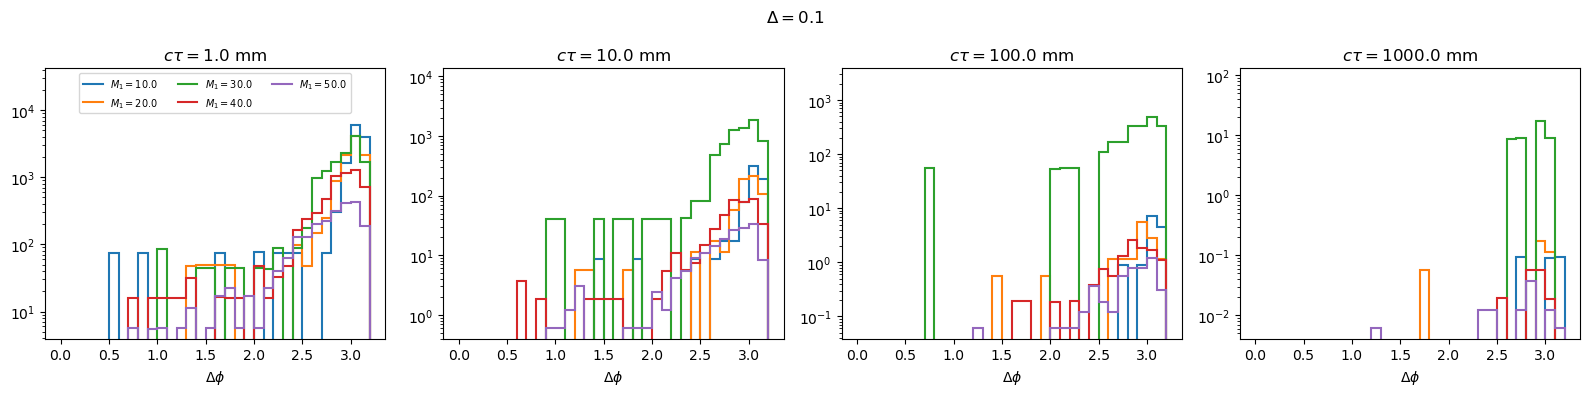

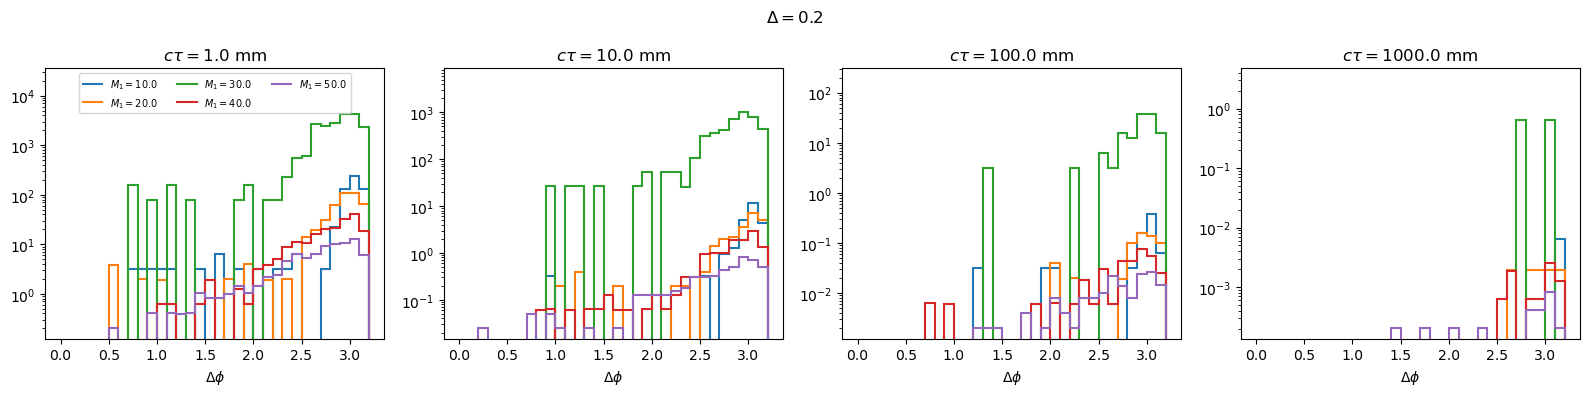

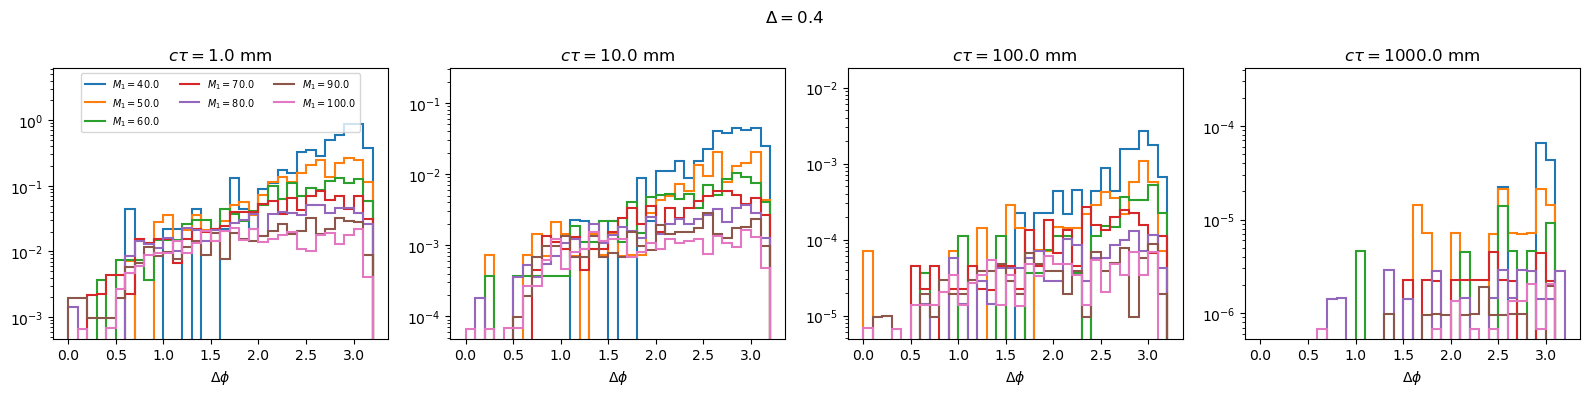

In [17]:
extra = lambda x: x[{"mtype":2}]
plot("sel_vtx_mindPhiJ_vs_matchType",None,extra=extra,rej=True,logy=True,rebin=1j)